In [3]:
from __future__ import print_function
import sys,os

import numpy as np
from scipy.stats import hypergeom # ,fisher_exact
from fisher import pvalue
import pandas as pd
 
import networkx as nx
print("NetworkX version",nx.__version__, file = sys.stderr) # should be < 2
import ndex2.client
import ndex2

import itertools
import warnings
import time
import datetime
import copy
import random

import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d 
import seaborn as sns

%matplotlib inline

NetworkX version 1.11


In [3]:
sys.path.append(os.path.abspath("/home/olya/SFU/Breast_cancer/DESMOND/"))
from method import prepare_input_data, print_network_stats
from method import precompute_RRHO_thresholds
from RWR import create_subnetworks_from_seeds #calc_distanse_matrix, group_seed_genes

In [4]:
########################## Read input paramethers ############
# the direction of dysreguation
direction = "UP" # "UP"  or "DOWN" 

# exprssoin matrix -- with standardized expression values
exprs_file = "TCGA_micro_nolog2.z.13K_common.tsv"#"METABRIC_micro_nolog2.z.13K_common.tsv"#"TCGA_RNAseq.RSEM.log2.z.13K_common.tsv"#
exprs_dir = "/home/olya/SFU/Breast_cancer/Expression/Harmonized_final/"
exprs_file =  exprs_dir + exprs_file 

# network -- must be in NDEX2 format 
netwroks_dir = "/home/olya/SFU/Breast_cancer/Networks/"
network_file = netwroks_dir + "BioGRID.cx" 

# seeds are optional and not used by default
with_seeds = True 
if with_seeds:
    seed_dir = "/home/olya/SFU/Breast_cancer/seed_genes/"
    seeds_file = seed_dir+"Somatic_drivers.seeds.txt"
    # if seeds provided, set RWR parameters 
    RWR_probability_thr = 0.001 # determines how large subnetworks will be; strongly depends on the network topology
    r = 0.3 # expected number of steps is 2.3 for r=0.3 a
    delta = 0.000001 # RWR tolerance 
    # read and preprocess input files: network, expressions and seeds
    exprs, network, seeds = prepare_input_data(exprs_file, network_file, seeds_file, verbose = True)
else: 
    # read and preprocess input files: network and expressions
    exprs, network = prepare_input_data(exprs_file, network_file, verbose = True)
    
# where to write the results
out_dir = "/home/olya/SFU/Breast_cancer/example_run/" # 
basename = "TCGA-micro"


# minimal number of patients in a module
min_n_patients = int(max(10,0.1*len(exprs.columns.values))) # set to nax(10, 10% of the cohort) 
# print("Fixed step for RRHO selected:", ,file =sys.stderr)
print("Mininal number of patients in a module:",min_n_patients ,file=sys.stderr)

# how to assign patients on edges
method = "RRHO" # "top_half" or "RRHO"
if method == "RRHO":
    # set RRHO parameters
    significance_thr=0.05
    fixed_step = int(max(1,0.02*len(exprs.columns.values))) # 5-10-20 ~15
    print("Fixed step for RRHO selected:", fixed_step, file =sys.stderr)                

if with_seeds:
    basename +="_r"+str(r)+"_T"+str(RWR_probability_thr)+"."+method+"_"+direction
else:
    basename +="."+method+"_"+direction
print("basename:", basename)


Input:
 	expressions: 13361 genes x 529 patients; 
	network: 16702 genes, 258257 edges in 13 connected components: 
	seeds: 38
4592 network nodes without expressoin profiles and 78735 edges excluded
1251 genes absent in the network excluded from the expression matrix


basename: TCGA-micro_r0.3_T0.001.RRHO_UP


Processed Input:
 	expressions: 11959 genes x 529 patients; 
	network: 16702 genes  179514 edges in 2 connected components: 
	seeds: 38
Mininal number of patients in a module: 52
Fixed step for RRHO selected: 10


In [5]:
print_network_stats(network, print_cc = True)

Undirected graph with 2 connected components; with 11959 nodes and 179514 edges;
Connected component 1 : 11956 nodes and 179512 edges
Connected component 2 : 3 nodes and 2 edges


In [6]:
if method == "RRHO":
     rrho_thresholds = precompute_RRHO_thresholds(exprs, fixed_step = fixed_step,significance_thr=significance_thr)

Precomputing RRHO thresholds 3.65126419067 s


# Step 0 [optional]:
### 0.1  Set RWR input
    * Compute normalized adjacency matrix $W_{norm}$ for graph $G$ representing PPI network  
    * see r and deltha in inputs 
### 0.2 Run RWR from evety seed gene taken independently
    - $G$ - undirected unweighted graph
    - $r$ - probability of restart; expected lenght of walk before the restart is (1-r)/r
    - $delta$ - threshold for $p_{t+1}-p_{t}$ - condition to stop RWR
### 0.3 Merge subnetworks which share seed genes 
 i.e. if two seed genes are closer than RWR_probability_thr, they will be in the same subnetwork

2.80133700371 s for adjacency matrix generation
39.135997057 s distance matrix generation for 38 seeds


component 1 
n_seeds 35 n_genes_in proximity 1619


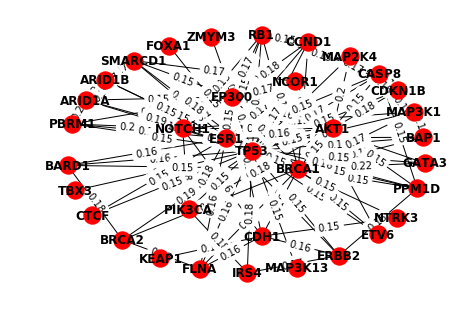

component 2 
n_seeds 1 n_genes_in proximity 43
component 3 
n_seeds 1 n_genes_in proximity 77
component 4 
n_seeds 1 n_genes_in proximity 7


Will search for modules in  4 following subnetworks
nodes: 1619 edges: 31342
nodes: 43 edges: 259
nodes: 77 edges: 173
nodes: 7 edges: 8


In [7]:
if with_seeds:
    resulted_subnets  = create_subnetworks_from_seeds(network,seeds,r,delta,RWR_probability_thr, verbose = True)

### Step1. Assign pateints to nodes 
1. every node gets sorted expression profile
2. every edge gets an associated set of patients - up- or down- regulated by both genes 
    * method = "top_halves" - takes an intersection of top-50% of both lists
    * method = "RRHO" - applies Rank-rank hypergeometric overlap

### Step2.  Probabilistic clustering
 1. set initial conditions
 2. do sampling until convergenes or no more than max_n_steps
 3. get consensus module membership
 
### Step 3.  Post-processing

## <s>[Greedy BFS]<\s>
### <s>2. Search for connected components <\s>
<s>Greedily grows connceted components starting from edges witrh maximal number of patients <\s>

### <s>3 Optimize the resulting modules<\s>
    <s>- optimize
    - merge 
    - filter<\s>
        

In [8]:
from method import  expression_profiles2nodes, assign_patients2edges, save_subnetworks,load_subnetworks
from method import plot_patient_ditsribution_and_mask_edges, count_emtpy_edges, count_masked_edges, write_modules

In [9]:
for i in range(0,len(resulted_subnets)):
    resulted_subnets[i] = expression_profiles2nodes(resulted_subnets[i], exprs, direction)
    resulted_subnets[i] = assign_patients2edges(resulted_subnets[i], method= method,
                                                    fixed_step=fixed_step,significance_thr=significance_thr,
                                                    rrho_thrs = rrho_thresholds)
    print("Subnetwork",i,"Edges without patients:",count_emtpy_edges(resulted_subnets[i], thr = 0))

Genes in expression matrix (529, 1619)
expression_profiles2nodes()	runtime: 0.86699 s
	 1000 edges processed. Average runtime per edge: 0.006337266445159912
	 2000 edges processed. Average runtime per edge: 0.005977502346038818
	 3000 edges processed. Average runtime per edge: 0.005947232723236084
	 4000 edges processed. Average runtime per edge: 0.0059567555785179135
	 5000 edges processed. Average runtime per edge: 0.00590014820098877
	 6000 edges processed. Average runtime per edge: 0.0058187179962793985
	 7000 edges processed. Average runtime per edge: 0.005693607636860438
	 8000 edges processed. Average runtime per edge: 0.005703650146722794
	 9000 edges processed. Average runtime per edge: 0.005733656512366401
	 10000 edges processed. Average runtime per edge: 0.0057979350090026855
	 11000 edges processed. Average runtime per edge: 0.005811344363472679
	 12000 edges processed. Average runtime per edge: 0.005867106715838114
	 13000 edges processed. Average runtime per edge: 0.0058

Subnetwork 0 Edges without patients: 14426


assign_patients2edges()	runtime, s: 1.8563 for subnetwork of 43 nodes 259 edges and  patients.
Genes in expression matrix (529, 77)
expression_profiles2nodes()	runtime: 0.06638 s


Subnetwork 1 Edges without patients: 131
Subnetwork 2 Edges without patients: 64
Subnetwork 3 Edges without patients: 4


assign_patients2edges()	runtime, s: 0.8746 for subnetwork of 77 nodes 173 edges and  patients.
Genes in expression matrix (529, 7)
expression_profiles2nodes()	runtime: 0.00672 s
assign_patients2edges()	runtime, s: 0.0488 for subnetwork of 7 nodes 8 edges and  patients.


In [10]:
# save subnetworks with assigned patients if necessary 
outfile_name =  out_dir + basename +".subnetworks.txt"
outfile_name

'/home/olya/SFU/Breast_cancer/example_run/TCGA-micro_r0.3_T0.001.RRHO_UP.subnetworks.txt'

In [11]:
print("edges masked:",count_masked_edges(resulted_subnets[0]))
save_subnetworks(resulted_subnets, outfile_name)
#resulted_subnets = load_subnetworks(outfile_name)

edges masked: 0


save_subnetworks() runtime 4.65 s


In [12]:
resulted_subnets2 = load_subnetworks(outfile_name)

load_subnetworks() runtime 8.56 s


edges 31342 edges masked: 16006
edges 259 edges masked: 139
edges 173 edges masked: 69
edges 8 edges masked: 4


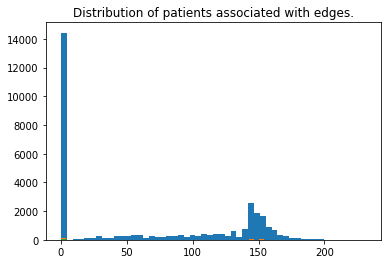

In [13]:
for subnet in resulted_subnets:
    plot_patient_ditsribution_and_mask_edges(subnet,min_n_patients=min_n_patients,title="Distribution of patients associated with edges.")
    print("edges",len(subnet.edges()),"edges masked:",count_masked_edges(subnet))

### 2. Sample module memberships

In [14]:
from method import  set_initial_distribution,sampling, get_consensus_module_membrship
from method import check_convergence_condition, restore_modules, get_genes, get_opt_pat_set
from post_processing import plot_bic_stats, write_modules, merge_modules

In [15]:
# initial distribution
edges, edgeNeighorhood, edge2module, moduleSizes,  edge2patients, nOnesPerPatientInModules = set_initial_distribution(resulted_subnets[0], exprs, basename, out_dir)

0.04 s runtime
loaded TCGA-micro_r0.3_T0.001.RRHO_UP.edgeNeighorhood.npy file in 0.15 s
0.0 s runtime


(15336, 529) (15336, 529)


0.89 s runtime


In [16]:
# sampling 
alpha = 0.1
beta_K = 1.0
max_n_steps  = 100
min_pletau_steps = 30
edge2module_history, edges_skip_history, edge2module_history_slice =  sampling(edges,  edgeNeighorhood, edge2module, edge2patients,  moduleSizes,nOnesPerPatientInModules, 
                                                                               max_n_steps=max_n_steps,alpha = alpha, beta_K = beta_K,min_pletau_steps = min_pletau_steps)

# save intermidiate results 
np.save(out_dir+basename+".edge2module_history.a="+str(alpha)+".b="+str(beta_K), edge2module_history)
np.save(out_dir+basename+".edges_skip_history.a="+str(alpha)+".b="+str(beta_K), edges_skip_history)
np.save(out_dir+basename+".edges.a="+str(alpha)+".b="+str(beta_K), edges)

step 1 n_changes 12902


54.9552 s runtime


step 2 n_changes 3799


30.8358 s runtime


step 3 n_changes 679


29.0731 s runtime


step 4 n_changes 181


30.0532 s runtime


step 5 n_changes 74


30.5793 s runtime


step 6 n_changes 39


31.9984 s runtime


step 7 n_changes 20


31.3661 s runtime


step 8 n_changes 17


31.6184 s runtime


step 9 n_changes 18


31.7012 s runtime


step 10 n_changes 17


29.3385 s runtime


step 11 n_changes 32


31.3604 s runtime


step 12 n_changes 27


28.5568 s runtime


step 13 n_changes 26


28.2816 s runtime


step 14 n_changes 23


29.2994 s runtime


step 15 n_changes 8


28.7687 s runtime


step 16 n_changes 12


28.9689 s runtime


step 17 n_changes 13


29.5871 s runtime


step 18 n_changes 8


29.4162 s runtime


step 19 n_changes 10


30.2551 s runtime


step 20 n_changes 10


29.8377 s runtime


step 21 n_changes 10


30.0454 s runtime


step 22 n_changes 8


30.5888 s runtime


step 23 n_changes 13


29.3395 s runtime


step 24 n_changes 10


29.9021 s runtime


step 25 n_changes 11


28.8315 s runtime


step 26 n_changes 5


33.5916 s runtime


step 27 n_changes 7


28.5274 s runtime


step 28 n_changes 7


31.5827 s runtime


step 29 n_changes 10


30.0199 s runtime


step 30 n_changes 6


30.1268 s runtime


step 31 n_changes 5


30.8842 s runtime


step 32 n_changes 9


29.8395 s runtime


step 33 n_changes 10


30.726 s runtime


step 34 n_changes 8


29.3066 s runtime


step 35 n_changes 6


29.0003 s runtime
The model converged after 35 steps.


In [20]:
alpha = 0.1
beta_K = 1.0
max_n_steps  = 100 
min_pletau_steps = 30
edge2module_history = np.load(out_dir+basename+".edge2module_history.a="+str(alpha)+".b="+str(beta_K)+".npy")
edges_skip_history = np.load(out_dir+basename+".edges_skip_history.a="+str(alpha)+".b="+str(beta_K)+".npy")
edges = np.load(out_dir+basename+".edges.a="+str(alpha)+".b="+str(beta_K)+".npy")
edge2module_history_slice = edge2module_history[-min_pletau_steps:]

In [21]:
# consensus edge-to-module membership
consensus_edge2module = get_consensus_module_membrship(edge2module_history_slice, edges)

	edge: 3315 counts: [ 3 13 14] 
	labels: 3315,3315,3315,9864,9864,9319,9864,9864,9319,9319,9864,9864,9319,9864,9864,9864,9319,9864,9319,9319,9319,9319,9864,9319,9864,9864,9319,9319,9864,9319


1.04 s runtime


empty modules: 13582 non-empty modules: 1754


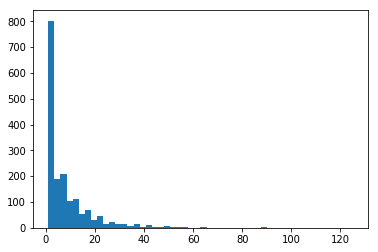

In [22]:
# make moduleSizes, nOnesPerPatientInModules corresponding to consensus module mebership 
moduleSizes, nOnesPerPatientInModules = restore_modules(consensus_edge2module,edges,resulted_subnets[0],exprs)

print("empty modules:", len([x for x in moduleSizes if x == 0]),
      "non-empty modules:",len([x for x in moduleSizes if x != 0]))
tmp = plt.hist(moduleSizes, bins=50, range=(1,max(moduleSizes)))

1256


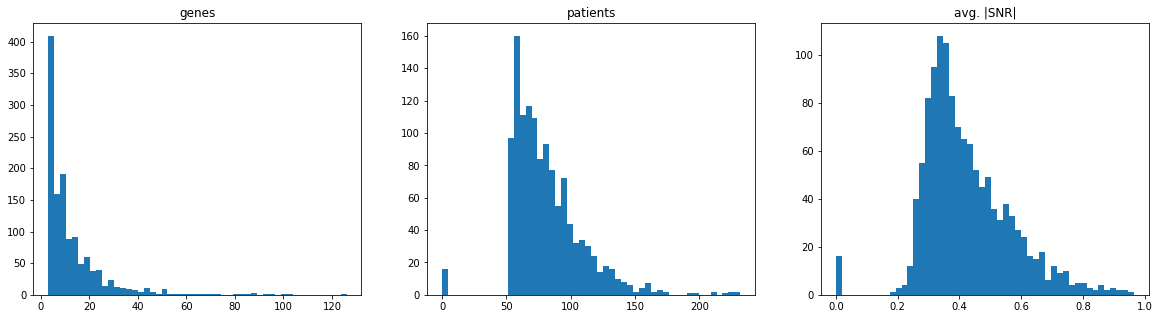

In [41]:
bics = []
for mid in range(0,len(moduleSizes)):
    if moduleSizes[mid]>1:
        genes = get_genes(mid,edge2module=consensus_edge2module,edges=edges)
        pats, thr, avgSNR = get_opt_pat_set(nOnesPerPatientInModules[mid,], moduleSizes[mid,],
                                            exprs, genes, min_n_patients=min_n_patients)
        bics.append({"genes":set(genes), "patients":set(pats), "avgSNR":avgSNR,"id":mid})


plot_bic_stats(bics)
print(len(bics))

### 3. Post-processing: Filter the resulting modules and do post-processing:
 * exclude all the modules with low SNR < 0.5
 * repeat until the list of modules is non-empty 
    * select module with maximal SNR
    * find all the candidates with at least 75% of mutual patinet ovelap and at least 1 gene shared
    * try merging with every candidate and calcuate new threshold with max. abs. SNR
    * select one with max SNR but with loss no more than 10 %
    * if any suitable candidates found - merge 
    * else save module and remove it from the list

In [42]:
min_SNR = 0.5
min_patient_overlap = 0.75 # at least 75 % of candidates 
allowed_SNR_decrease  = 0.1 # maximum allowed % of SNR decrease when merge two modules 
# -i.e. new module loses after merge no more than 10% of SNR 

313


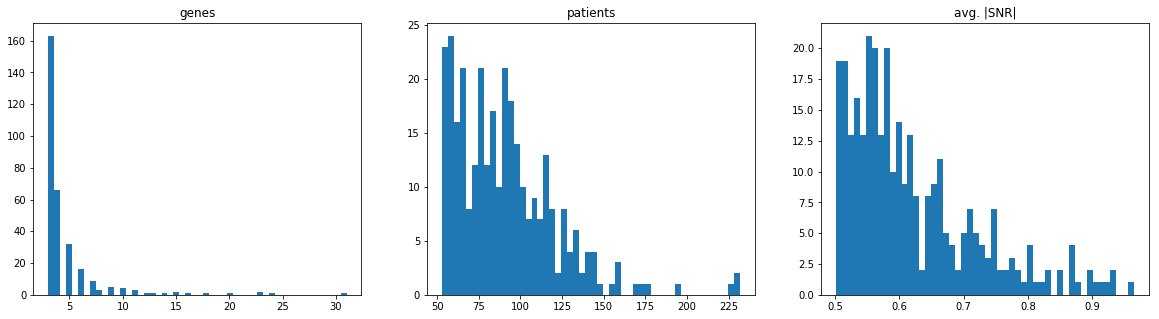

In [43]:
filtered_bics = []
for bic in bics:
    if bic["avgSNR"] > min_SNR:
        filtered_bics.append(copy.copy(bic))
plot_bic_stats(filtered_bics)
print(len(filtered_bics))

In [46]:
resulting_modules = merge_modules(filtered_bics, copy.copy(nOnesPerPatientInModules),copy.copy(moduleSizes),exprs,SNRs = [],
                              min_patient_overlap = min_patient_overlap,
                              min_acceptable_SNR_percent=1-allowed_SNR_decrease, verbose= False)

0.15 s runtime


0 module: 4437 SNR 0.966 pats 175 genes 3
1 module: 13374 SNR 0.938 pats 156 genes 4
2 module: 9262 SNR 0.927 pats 94 genes 4
3 module: 10933 SNR 0.918 pats 232 genes 4
4 module: 13929 SNR 0.915 pats 218 genes 12
5 module: 10614 SNR 0.906 pats 136 genes 5
6 module: 8165 SNR 0.892 pats 157 genes 3
7 module: 12438 SNR 0.892 pats 172 genes 3
8 module: 782 SNR 0.87 pats 157 genes 3
9 module: 11261 SNR 0.867 pats 56 genes 9
10 module: 13580 SNR 0.866 pats 146 genes 5
11 module: 14145 SNR 0.864 pats 75 genes 3
12 module: 13907 SNR 0.854 pats 122 genes 3
13 module: 14154 SNR 0.847 pats 144 genes 4
14 module: 12439 SNR 0.834 pats 58 genes 5
15 module: 12909 SNR 0.827 pats 67 genes 4
16 module: 13370 SNR 0.826 pats 149 genes 3
17 module: 10904 SNR 0.817 pats 83 genes 7
18 module: 4535 SNR 0.803 pats 128 genes 3
19 module: 12375 SNR 0.803 pats 127 genes 3
20 module: 9781 SNR 0.801 pats 134 genes 3
312


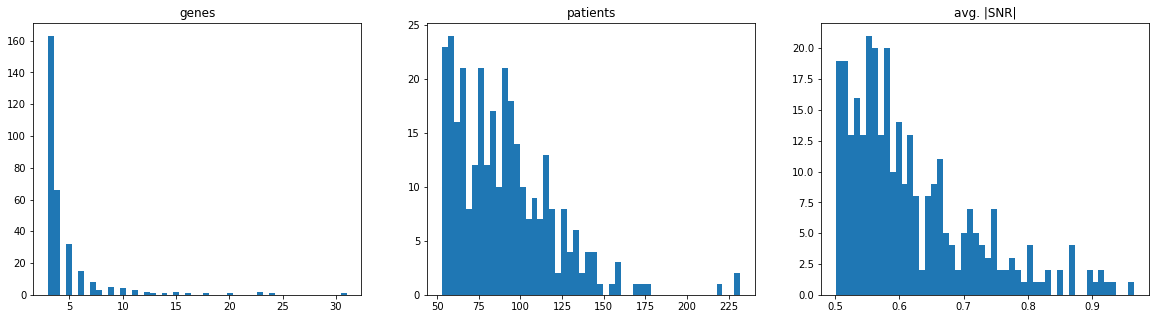

In [47]:
i=0
for bic in resulting_modules:
    if bic["avgSNR"]> 0.8:
        print(i,"module:",bic["id"],"SNR",bic["avgSNR"], "pats",len(bic["patients"]), "genes", len(bic["genes"]))
    i+=1
print(len(resulting_modules))
plot_bic_stats(resulting_modules)

In [48]:
def write_modules(bics,file_name):
    fopen = open(file_name,"w")
    for bic in bics:
        print("id:\t"+str(bic["id"]), file=fopen)
        print("average SNR:\t"+str(bic["avgSNR"]),file=fopen)
        print("genes:\t"+" ".join(bic["genes"]),file=fopen)
        print("patients:\t"+" ".join(bic["patients"]),file=fopen)
    fopen.close()
    print(str(len(bics)),"modules written to",file_name,file = sys.stderr)
    
file_name = out_dir+basename+".minSNR_"+str(min_SNR)+".modules.txt"
write_modules(resulting_modules,file_name)

312 modules written to /home/olya/SFU/Breast_cancer/example_run/TCGA-micro_r0.3_T0.001.RRHO_UP.minSNR_0.5.modules.txt
